<a href="https://colab.research.google.com/github/antonkravchenko2001/Machine_translation_English_to_Russian/blob/master/Russian_to_English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

{{badge}}

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, SpatialDropout1D,Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf 
from sklearn.model_selection import train_test_split

In [ ]:
import json

In [ ]:
num_samples = 200000
max_num_words = 40000

In [ ]:
def parse(data_path):
    inputs = []
    targets = []
    c = 0
    with open(data_path, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
    for line in lines[: len(lines) - 1]:
        c += 1
        if c > 200000:
            break
        input_, target, _ = line.split('\t')
        target = 'start ' + target + " end"
        inputs.append(input_)
        targets.append(target)
    return inputs, targets

In [ ]:
def tokenize(text):
    tokenizer = Tokenizer(num_words=40000)
    tokenizer.fit_on_texts(text)
    text = tokenizer.texts_to_sequences(text)
    return text, tokenizer.word_index, {v: k for k, v in tokenizer.word_index.items()}

In [ ]:
def max_sequence_length(text):
    length_list = []
    for sentence in text:
        l = 0
        for _ in sentence:
            l += 1
        length_list.append(l)
    return max(length_list)

In [ ]:
def batch_generator(x, y, batch_size=100):
    while True:
        for i in range(0, len(x), batch_size):
            encoder_inputs = pad_sequences(x[i:i+batch_size], maxlen=max_sequence_length(input_text), padding='pre')
            decoder_inputs = []
            decoder_outputs = []
            for j, txt in enumerate(y[i:i+batch_size]):
                decoder_inputs.append(txt[:-1])
                decoder_outputs.append(txt[1:])
            decoder_inputs = pad_sequences(decoder_inputs,maxlen=max_sequence_length(target_text)-1, padding='post')
            decoder_outputs = pad_sequences(decoder_outputs,maxlen=max_sequence_length(target_text)-1,padding='post')
            yield ([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
input_text, target_text = parse('/content/drive/My Drive/machine_translation/eng-rus.txt')

In [ ]:
input_text, input_dict, input_dict_r = tokenize(input_text)
target_text, target_dict, target_dict_r = tokenize(target_text)

In [ ]:
latent_dim=256

In [ ]:
enc_inp = Input(shape=(None,))
enc_emb_layer = Embedding(len(input_dict)+1, latent_dim)
enc_emb = enc_emb_layer(enc_inp)
enc_dropout = SpatialDropout1D(0.3)
enc_emb = enc_dropout(enc_emb)
enc_lstm_1 = LSTM(latent_dim, return_sequences=True)
enc_lstm_out =  enc_lstm_1(enc_emb)
batch_norm_1 = BatchNormalization()
enc_lstm_out = batch_norm_1(enc_lstm_out + enc_emb, training=True)
enc_lstm_2 = LSTM(latent_dim, return_state=True)
enc_out, h, c = enc_lstm_2(enc_lstm_out)
enc_states = [h, c]
dec_inp = Input(shape=(None,))
dec_emb_layer = Embedding(len(target_dict)+1, latent_dim)
dec_emb = dec_emb_layer(dec_inp)
dec_dropout = SpatialDropout1D(0.2)
dec_emb = dec_dropout(dec_emb)
dec_lstm_1 = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_out, _, _ = dec_lstm_1(dec_emb, initial_state=enc_states)
dec_lstm_2 = LSTM(latent_dim, return_sequences=True, return_state=True)
out,_,_ = dec_lstm_2(dec_out, initial_state=enc_states)
dec_dense_layer = Dense(len(target_dict)+1, activation="softmax")
out = dec_dense_layer(out)
model = Model([enc_inp, dec_inp], out)

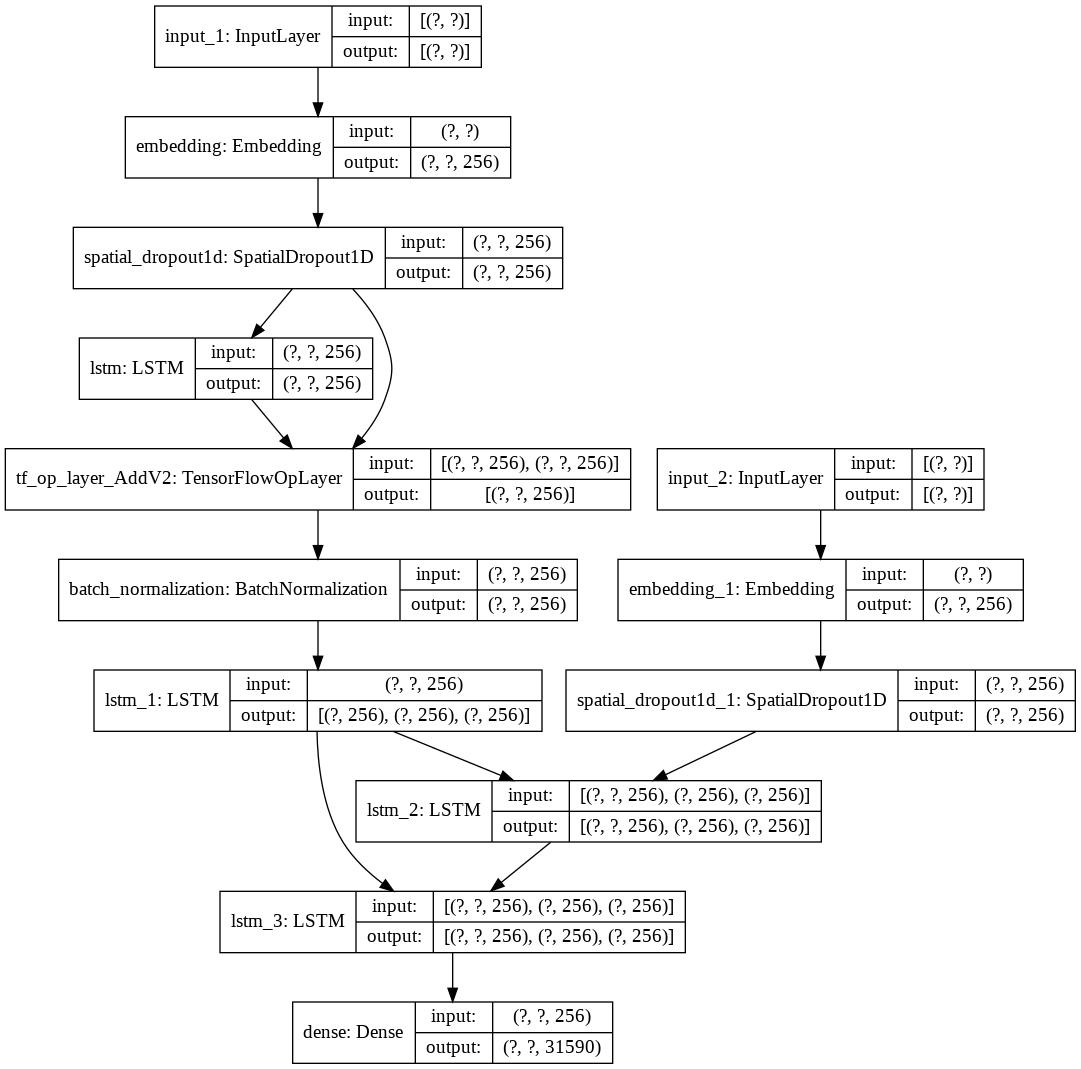

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def scheduler(epoch, lr):
    if epoch < 31:
        return lr
    if epoch > 30 and epoch < 41:
        return 0.5*lr
    if epoch > 40 and epoch < 51:
        return 0.2*lr
    if epoch > 50:
        return 0.1*lr

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
optimizer = Adam(0.01)
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
sparse_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [ ]:
model.compile(optimizer=optimizer, loss = loss_func, metrics=[sparse_accuracy])

In [ ]:
train_data = batch_generator(input_text, target_text, batch_size=1000)

In [ ]:
model.fit(train_data, epochs=60, verbose=1,
    shuffle=True, callbacks=[callback], steps_per_epoch = 200)

Epoch 1/60
200/200 [==============================] - 57s 283ms/step - loss: 2.7040 - sparse_categorical_accuracy: 0.6494
Epoch 2/60
200/200 [==============================] - 57s 285ms/step - loss: 1.7424 - sparse_categorical_accuracy: 0.7343
Epoch 3/60
200/200 [==============================] - 57s 285ms/step - loss: 1.1727 - sparse_categorical_accuracy: 0.7937
Epoch 4/60
200/200 [==============================] - 58s 288ms/step - loss: 0.8309 - sparse_categorical_accuracy: 0.8321
Epoch 5/60
200/200 [==============================] - 57s 285ms/step - loss: 0.6440 - sparse_categorical_accuracy: 0.8564
Epoch 6/60
200/200 [==============================] - 57s 286ms/step - loss: 0.5289 - sparse_categorical_accuracy: 0.8740
Epoch 7/60
200/200 [==============================] - 57s 287ms/step - loss: 0.4621 - sparse_categorical_accuracy: 0.8856
Epoch 8/60
200/200 [==============================] - 57s 286ms/step - loss: 0.4097 - sparse_categorical_accuracy: 0.8953
Epoch 9/60
200/200 [====

In [ ]:
model.save('/content/drive/My Drive/machine_translation/training_model.h5')

In [ ]:
encoder_model = Model(enc_inp, enc_states)
encoder_model.save('/content/drive/My Drive/machine_translation/encoder.h5')
h1 = Input(shape=(latent_dim,))
c1 = Input(shape=(latent_dim,))
h2 = Input(shape=(latent_dim,))
c2 = Input(shape=(latent_dim,))
states1 = [h1, c1]
states2 = [h2, c2]
dec_inputs_single = Input(shape=(1,))
dec_emb_single = dec_emb_layer(dec_inputs_single)
dec_outputs_single, h3, c3 = dec_lstm_1(dec_emb_single, initial_state=states1)
states3 = [h3, c3]
dec_outputs, h4,c4 = dec_lstm_2(dec_outputs_single, initial_state=states2)
states4 = [h4, c4]
dec_outputs = dec_dense_layer(dec_outputs)
decoder_model = Model([dec_inputs_single] + [h1, c1, h2, c2], [dec_outputs] + [h3, c3, h4, c4])
decoder_model.save('/content/drive/My Drive/machine_translation/decoder.h5')

In [ ]:
def encode(seq):
    seq = seq.lower()
    seq = seq.split()
    for i in range(len(seq)):
        seq[i] = input_dict[seq[i]]
    seq = np.array(seq)
    seq = np.reshape(seq, (1, -1))
    seq = pad_sequences(seq, maxlen=max_sequence_length(input_text), padding="pre")
    return seq

In [ ]:
def translate(input_seq):
    h1, c1 = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_dict['start']
    eos = target_dict['end']
    output_sentence = []
    current_state = [h1, c1, h1, c1]
    for _ in range(20):
        output_tokens, h3, c3, h4, c4 = decoder_model.predict([target_seq] + current_state)
        idx = np.argmax(output_tokens[0, 0, :])
        if eos == idx:
            break
        word = ''
        if idx > 0:
            word = target_dict_r[str(idx)]
            output_sentence.append(word)
        target_seq[0, 0] = idx
        current_state = [h3, c4, h4, c4]
    return ' '.join(output_sentence)

In [ ]:
with open('/content/drive/My Drive/machine_translation/input_dict.json', 'w') as fp:
    json.dump(input_dict, fp)

In [ ]:
with open('/content/drive/My Drive/machine_translation/input_dict.json', 'r') as fp:
    input_dict = json.load(fp)

In [ ]:
with open('/content/drive/My Drive/machine_translation/target_dict_r.json', 'w') as fp:
    json.dump(target_dict_r, fp)

In [ ]:
with open('/content/drive/My Drive/machine_translation/target_dict_r.json', 'r') as fp:
    target_dict_r = json.load(fp)

In [ ]:
s = encode('hello')

In [ ]:
max_sequence_length(input_text)

8

In [ ]:
target_dict['end']

2